# Ran full training

In [1]:
import importlib
import train
importlib.reload(train)
from train import MLP, train


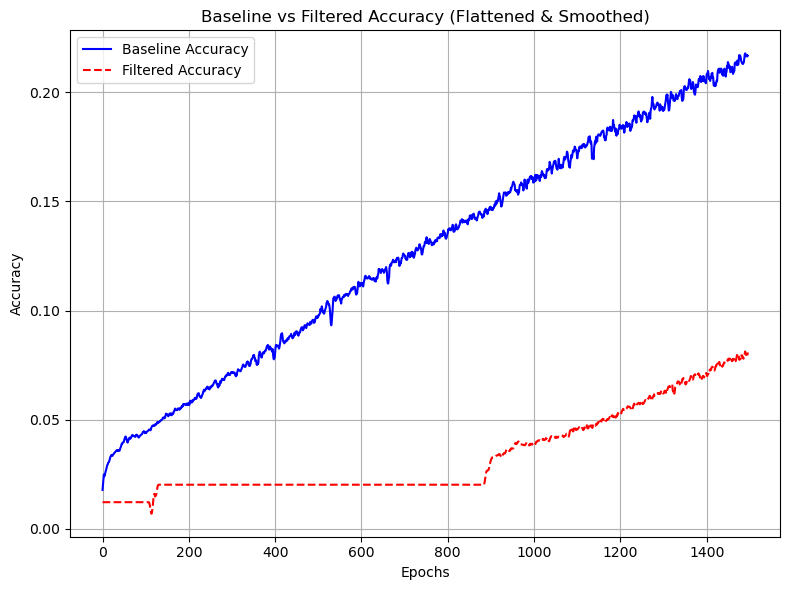


🔍 Zooming in on Epochs 120–149 for subtle rank changes...


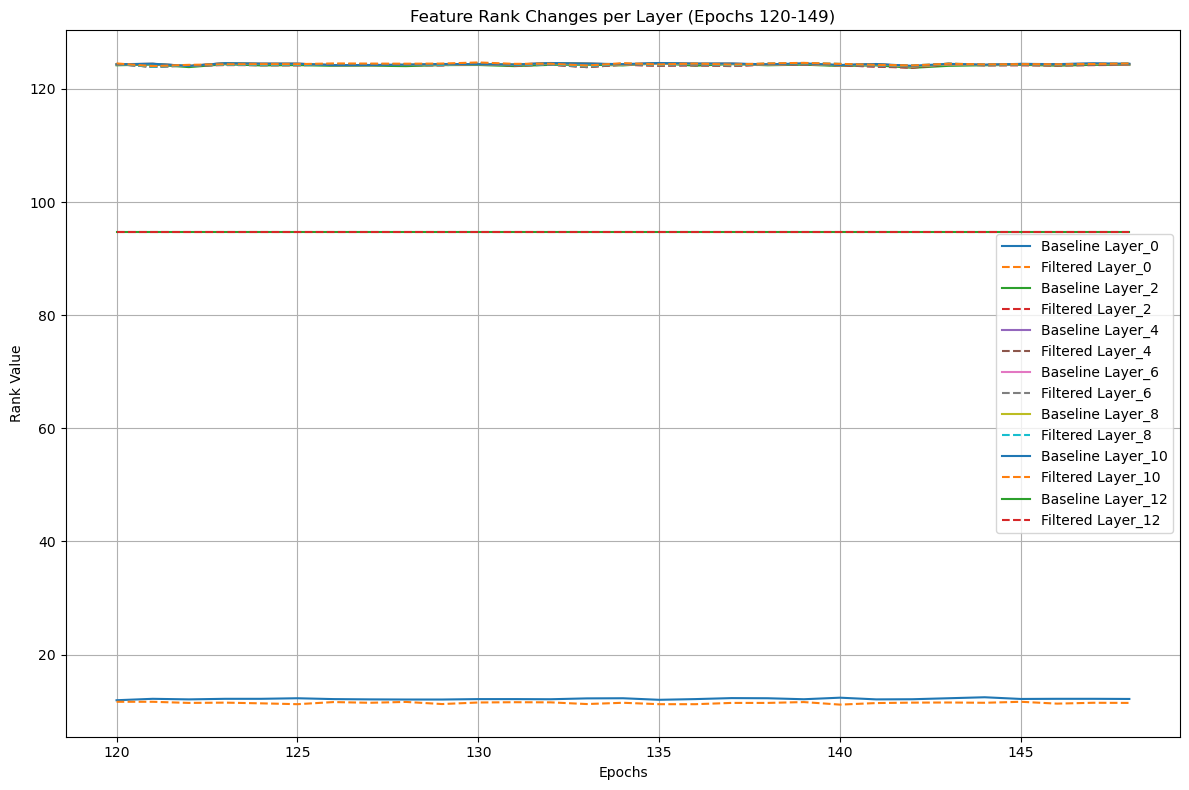


🔬 Plotting rank delta for Epochs 120–149...


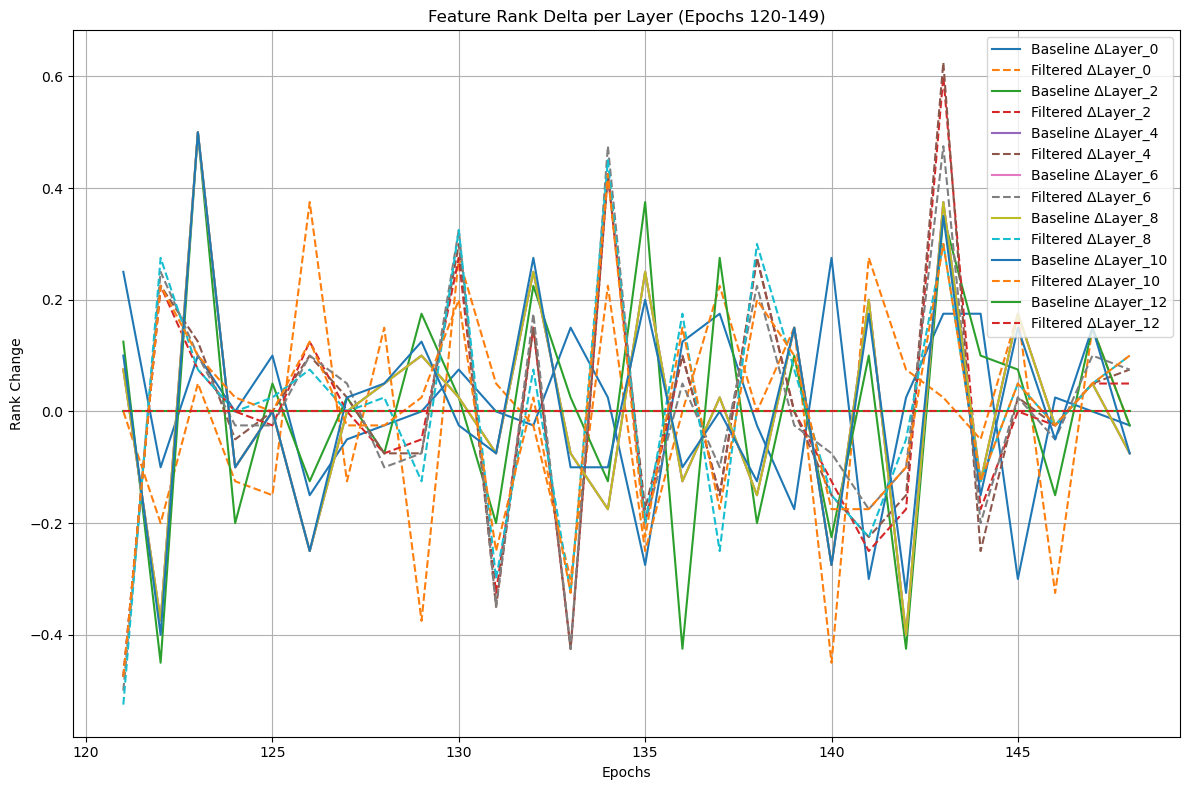


🧩 Plotting layer-specific dynamics (Epochs 120–149)...

📊 Plotting for Layer: Layer_0


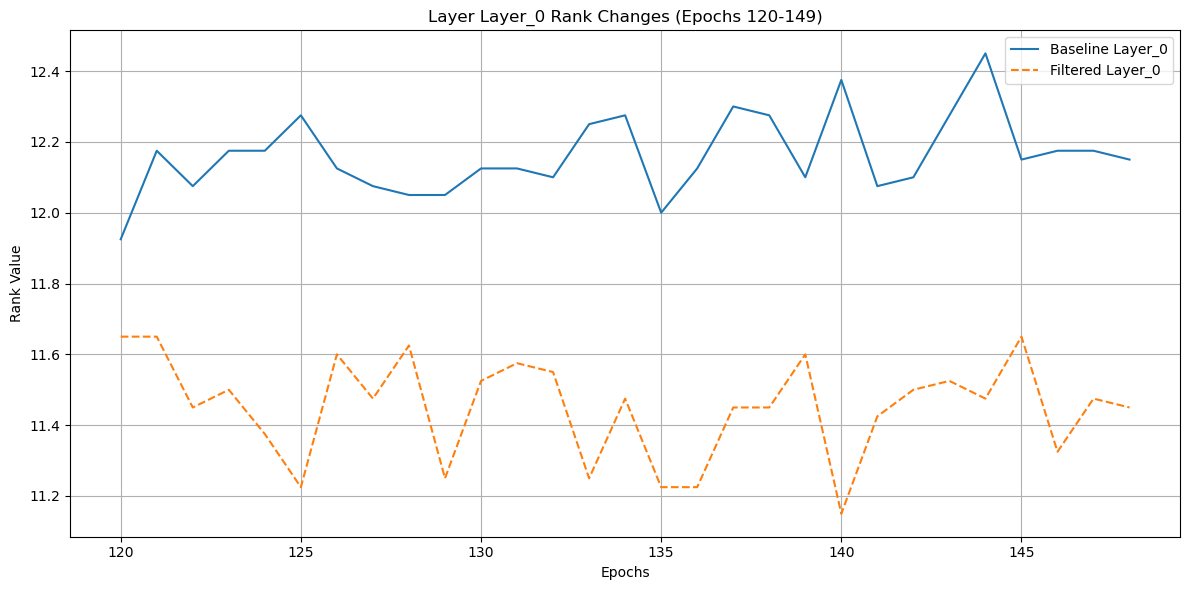


📊 Plotting for Layer: Layer_2


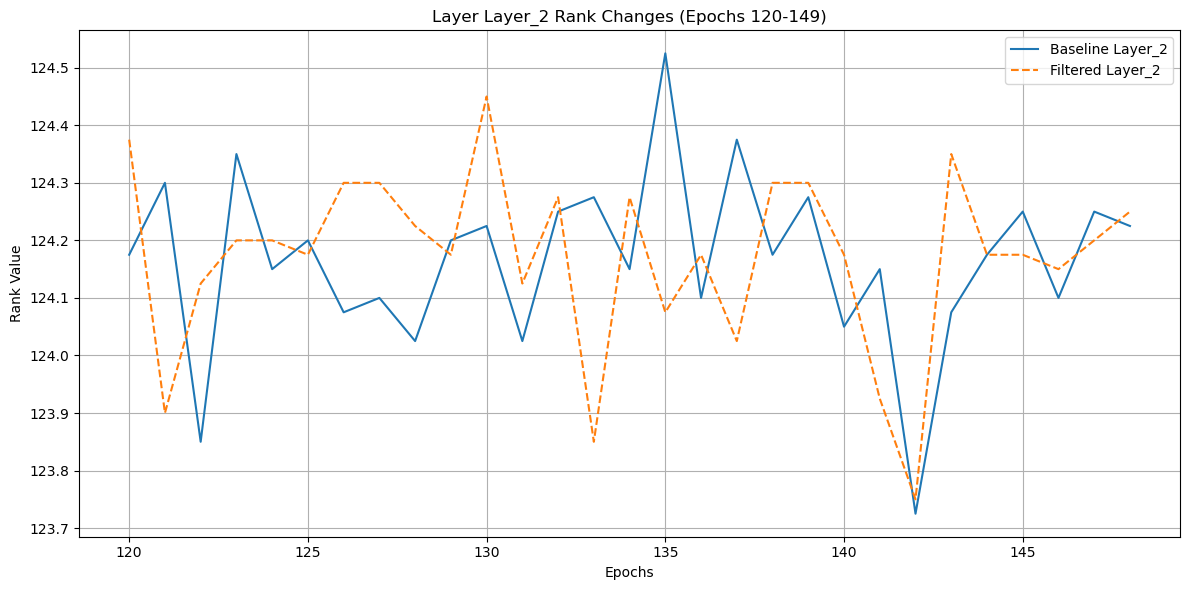


📊 Plotting for Layer: Layer_4


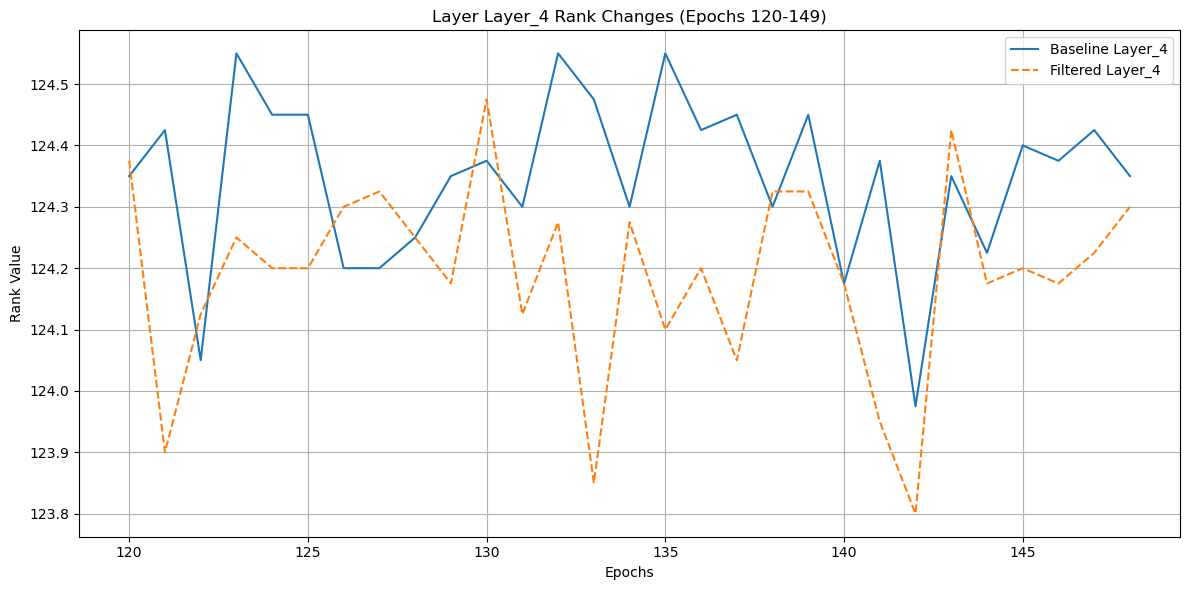


📊 Plotting for Layer: Layer_6


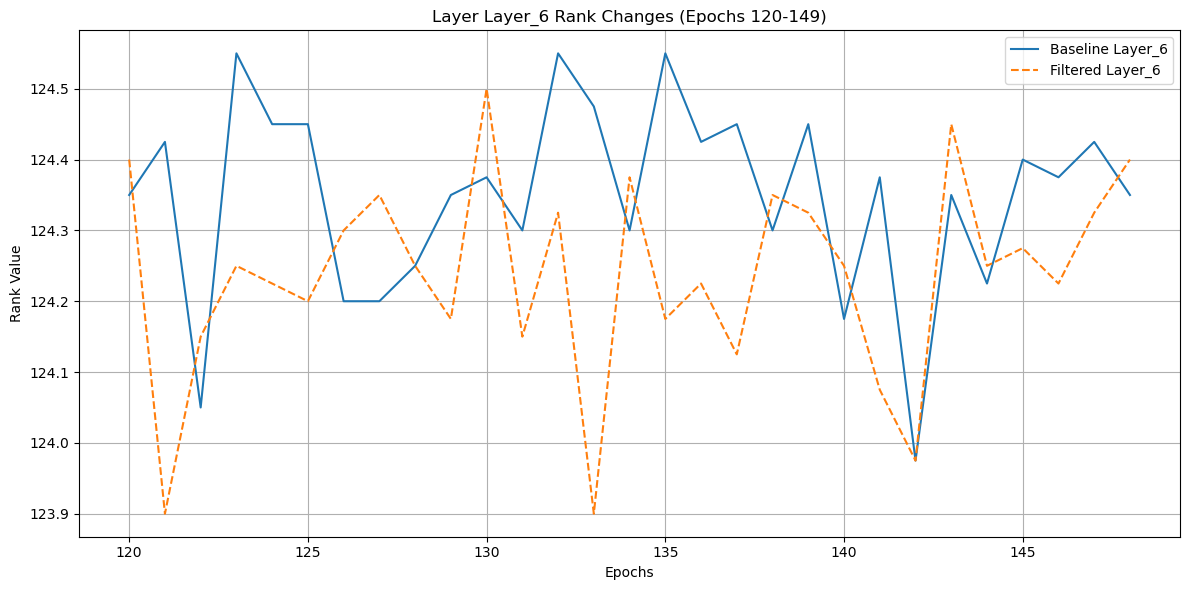


📊 Plotting for Layer: Layer_8


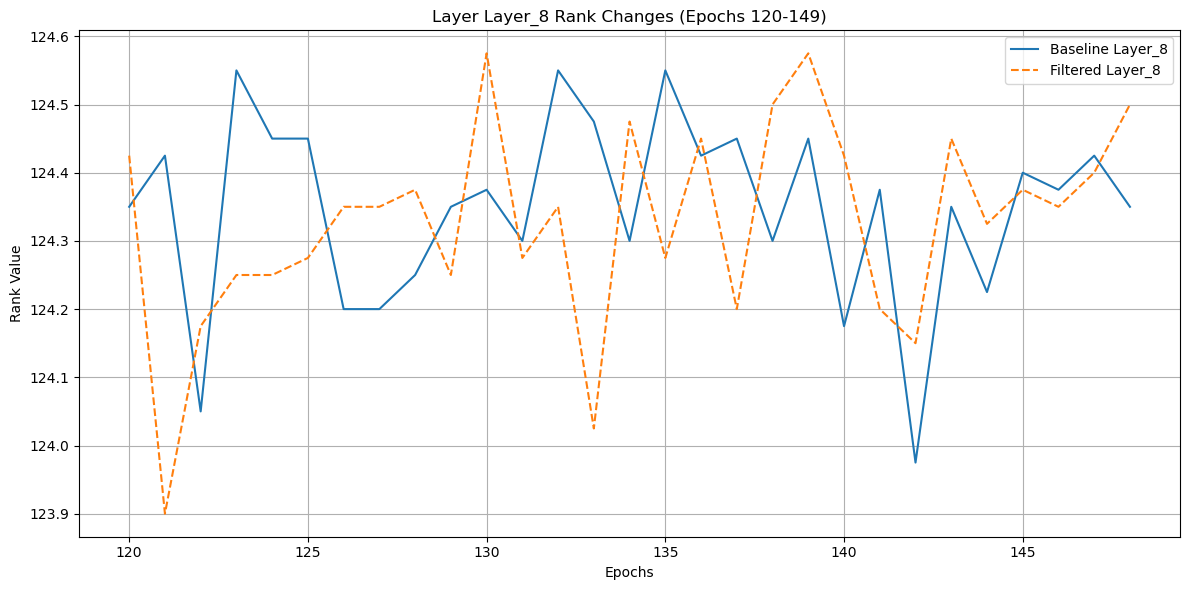


📊 Plotting for Layer: Layer_10


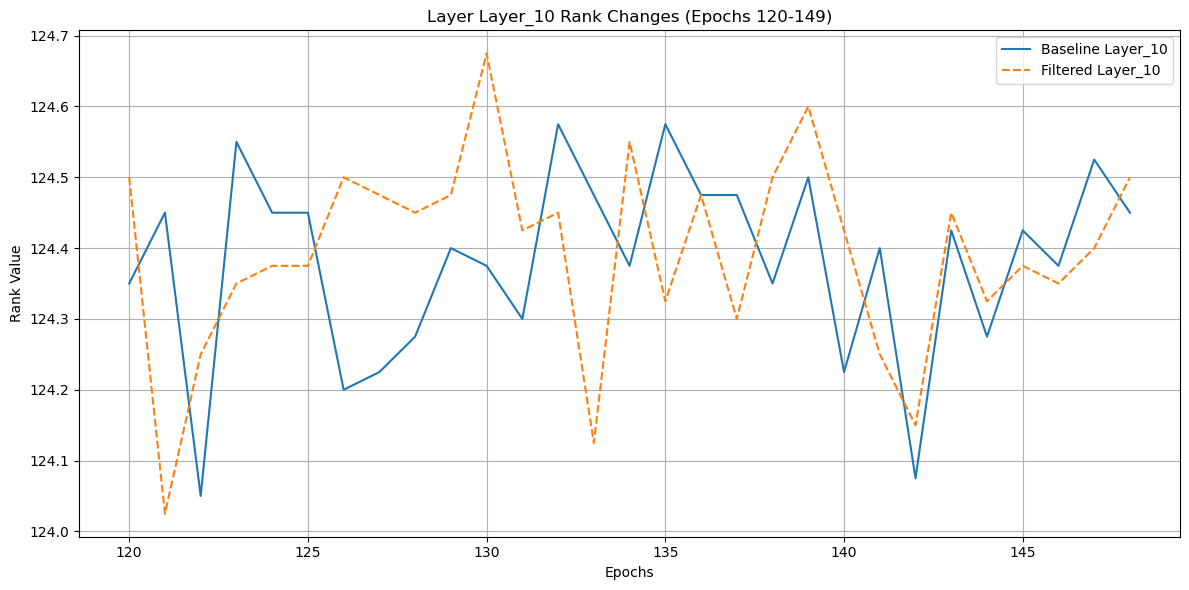


📊 Plotting for Layer: Layer_12


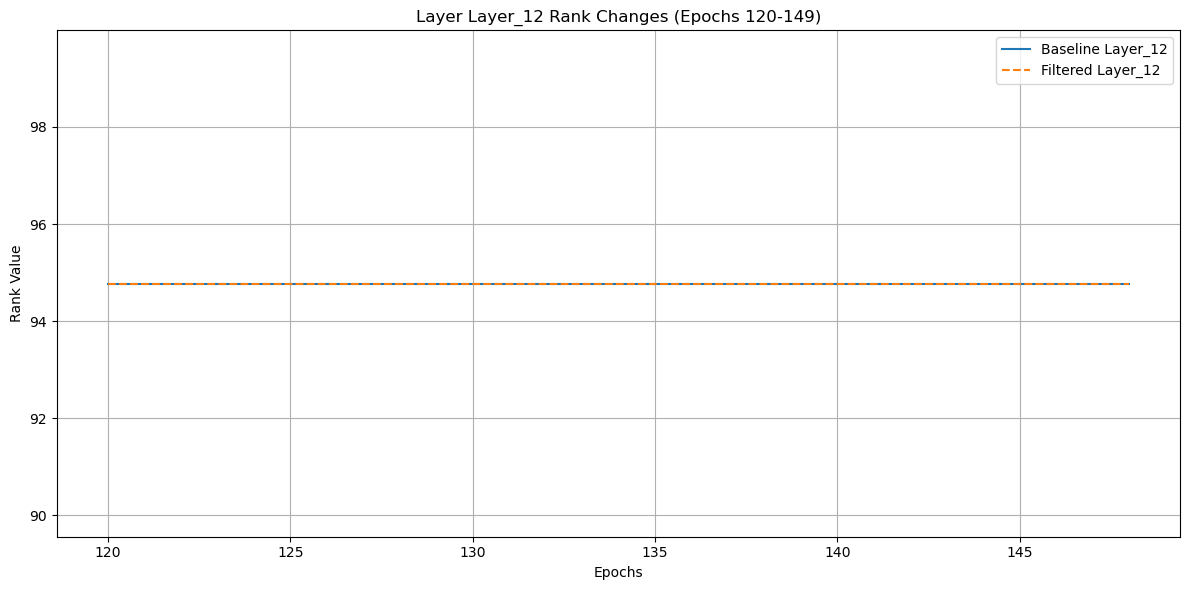

In [2]:
import torch
import matplotlib.pyplot as plt
from train import MLP, train
from utils import get_dataloader
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Flatten Data Function with Filtering ---
def flatten_data(data):
    """Flattens and filters only numerical data from nested lists or tuples."""
    flat_list = []
    for item in data:
        if isinstance(item, (list, tuple, np.ndarray)):
            flat_list.extend([x for x in item if isinstance(x, (int, float))])
        elif isinstance(item, (int, float)):
            flat_list.append(item)
        else:
            print(f"⚠️ Skipped non-numeric entry: {type(item)} - {item}")
    return np.array(flat_list).flatten()


#  Smoothing Function 
def moving_average(data, window_size=5):
    """Applies a moving average to smooth out accuracy curves."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')


# Plot Accuracy Function 
def plot_accuracy(baseline_acc, filtered_acc, smooth=True, window_size=5):
    plt.figure(figsize=(8, 6))

    if smooth:
        baseline_acc = moving_average(baseline_acc, window_size)
        filtered_acc = moving_average(filtered_acc, window_size)

    plt.plot(baseline_acc, label="Baseline Accuracy", color='b')
    plt.plot(filtered_acc, label="Filtered Accuracy", linestyle="--", color='r')
    plt.title("Baseline vs Filtered Accuracy (Flattened & Smoothed)")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


#  Plot Rank Changes Function 
def plot_rank_changes(baseline_ranks, filtered_ranks, start_epoch=0, end_epoch=None):
    total_epochs = len(baseline_ranks)
    if end_epoch is None or end_epoch > total_epochs:
        end_epoch = total_epochs

    if start_epoch >= end_epoch:
        print(f"⚠️ Invalid epoch range: start_epoch={start_epoch}, end_epoch={end_epoch}. Skipping plot.")
        return

    if start_epoch >= total_epochs:
        print(f"⚠️ Start epoch {start_epoch} exceeds total epochs {total_epochs}. Skipping plot.")
        return

    epochs = range(start_epoch, end_epoch)
    layers = baseline_ranks[0].keys()

    plt.figure(figsize=(12, 8))
    for layer in layers:
        baseline_layer_ranks = [epoch[layer] for epoch in baseline_ranks][start_epoch:end_epoch]
        filtered_layer_ranks = [epoch[layer] for epoch in filtered_ranks][start_epoch:end_epoch]
        plt.plot(epochs, baseline_layer_ranks, label=f"Baseline {layer}", linestyle='-')
        plt.plot(epochs, filtered_layer_ranks, label=f"Filtered {layer}", linestyle='--')

    plt.title(f"Feature Rank Changes per Layer (Epochs {start_epoch}-{end_epoch})")
    plt.xlabel("Epochs")
    plt.ylabel("Rank Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Layer-Specific Plot Function 
def plot_single_layer(baseline_ranks, filtered_ranks, layer_name, start_epoch=0, end_epoch=None):
    total_epochs = len(baseline_ranks)
    if end_epoch is None or end_epoch > total_epochs:
        end_epoch = total_epochs

    if start_epoch >= end_epoch:
        print(f"⚠️ Invalid epoch range: start_epoch={start_epoch}, end_epoch={end_epoch}. Skipping plot.")
        return

    if start_epoch >= total_epochs:
        print(f"⚠️ Start epoch {start_epoch} exceeds total epochs {total_epochs}. Skipping plot.")
        return

    epochs = range(start_epoch, end_epoch)
    baseline_layer_ranks = [epoch[layer_name] for epoch in baseline_ranks][start_epoch:end_epoch]
    filtered_layer_ranks = [epoch[layer_name] for epoch in filtered_ranks][start_epoch:end_epoch]

    plt.figure(figsize=(12, 6))
    plt.plot(epochs, baseline_layer_ranks, label=f"Baseline {layer_name}", linestyle='-')
    plt.plot(epochs, filtered_layer_ranks, label=f"Filtered {layer_name}", linestyle='--')
    plt.title(f"Layer {layer_name} Rank Changes (Epochs {start_epoch}-{end_epoch})")
    plt.xlabel("Epochs")
    plt.ylabel("Rank Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Plot Rank Delta Function 
def plot_rank_delta(baseline_ranks, filtered_ranks, start_epoch=0, end_epoch=None):
    total_epochs = len(baseline_ranks)
    if end_epoch is None or end_epoch > total_epochs:
        end_epoch = total_epochs

    if start_epoch >= end_epoch:
        print(f"⚠️ Invalid epoch range: start_epoch={start_epoch}, end_epoch={end_epoch}. Skipping plot.")
        return

    if start_epoch >= total_epochs:
        print(f"⚠️ Start epoch {start_epoch} exceeds total epochs {total_epochs}. Skipping plot.")
        return

    epochs = range(start_epoch + 1, end_epoch)
    layers = baseline_ranks[0].keys()

    plt.figure(figsize=(12, 8))
    for layer in layers:
        baseline_delta = [baseline_ranks[i][layer] - baseline_ranks[i - 1][layer] for i in epochs if i < total_epochs]
        filtered_delta = [filtered_ranks[i][layer] - filtered_ranks[i - 1][layer] for i in epochs if i < total_epochs]
        plt.plot(range(start_epoch + 1, start_epoch + 1 + len(baseline_delta)), baseline_delta, label=f"Baseline Δ{layer}", linestyle='-')
        plt.plot(range(start_epoch + 1, start_epoch + 1 + len(filtered_delta)), filtered_delta, label=f"Filtered Δ{layer}", linestyle='--')

    plt.title(f"Feature Rank Delta per Layer (Epochs {start_epoch}-{end_epoch})")
    plt.xlabel("Epochs")
    plt.ylabel("Rank Change")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Extended Analysis with Dynamic Epoch Range 
def extended_analysis(start_epoch=0, end_epoch=None):
    torch.serialization.add_safe_globals({np.core.multiarray.scalar, np.dtype, np.float64, np.int64})
    results_1500 = torch.load("results_1500_epochs.pth", map_location=torch.device('cpu'), weights_only=False)

    baseline_acc_flat = flatten_data(results_1500["baseline_acc"])
    filtered_acc_flat = flatten_data(results_1500["filtered_acc"])
    plot_accuracy(baseline_acc_flat, filtered_acc_flat)

    if end_epoch is None:
        end_epoch = len(results_1500["baseline_ranks"])

    if start_epoch >= len(results_1500["baseline_ranks"]):
        print(f"⚠️ Start epoch {start_epoch} exceeds available data. Maximum epoch: {len(results_1500['baseline_ranks']) - 1}")
        return

    print(f"\n🔍 Zooming in on Epochs {start_epoch}–{end_epoch} for subtle rank changes...")
    plot_rank_changes(results_1500["baseline_ranks"], results_1500["filtered_ranks"], start_epoch=start_epoch, end_epoch=end_epoch)

    print(f"\n🔬 Plotting rank delta for Epochs {start_epoch}–{end_epoch}...")
    plot_rank_delta(results_1500["baseline_ranks"], results_1500["filtered_ranks"], start_epoch=start_epoch, end_epoch=end_epoch)

    print(f"\n🧩 Plotting layer-specific dynamics (Epochs {start_epoch}–{end_epoch})...")
    for layer in results_1500["baseline_ranks"][0].keys():
        print(f"\n📊 Plotting for Layer: {layer}")
        plot_single_layer(results_1500["baseline_ranks"], results_1500["filtered_ranks"], layer, start_epoch=start_epoch, end_epoch=end_epoch)


if __name__ == "__main__":
    extended_analysis(start_epoch=120, end_epoch=149)  
